<a href="https://colab.research.google.com/github/r-jschnoor/AdvRob/blob/main/hw0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python implementation of training and testing neural network on MNIST & CIFAR-10

This homework assignment provides a comprehensive overview of a fundamental deep learning pipeline. It begins with data loading and preprocessing, progresses through training neural network architectures from scratch, and culminates with the fine-tuning of pretrained models to enhance performance and leverage transfer learning. We also introduce the basic evaluation matrices that are utilized to evaluate the model's performance on a classification task.

The objective of this assignment is to provide a structured introduction to the core components of a deep learning workflow. Specifically, it aims to:

1. Familiarize students with essential libraries commonly used in neural network development and training.

2. Introduce standard image datasets available through the torchvision library, along with commonly applied data transformations.

3. Demonstrate the standard neural network training pipeline using two baseline architectures: one based on fully connected (linear) layers and the other utilizing convolutional neural networks (CNNs).

4. Introduce the concept of transfer learning through fine-tuning a pretrained transformer-based model for a specific classification task.

5. Provide basic visualization tools for inspecting input samples, model predictions, and evaluation results.



## 1. Setting Up the Environment

Here we install and import all the libraries we are going to utilize in our code moving ahead!


In [ ]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
## Model Training Libraries

import timm
import torch
import torch.nn as nn
import torch.optim as optim

## Data Loading and Transformation Libraries

import torchvision
import torchvision.transforms as transforms
import torch.utils.data
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets

## Evaluation and Visualisation Libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Utility Libraries
import numpy as np
import random
from tqdm import tqdm

We use GPU if available; otherwise, CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Utility Functions

In [ ]:
def set_seed(seed=42):
    """
    This function `set_seed` ensures reproducibility in experiments by setting fixed seeds across
    multiple libraries that influence randomness, including Python's `random`, NumPy, and PyTorch
    (for both CPU and GPU computations). Additionally, it configures PyTorch's backend to produce
    deterministic results, making model training and evaluation results consistent across runs.
    """
    random.seed(seed)               # Set seed for random module
    np.random.seed(seed)            # Set seed for numpy
    torch.manual_seed(seed)         # Set seed for pytorch
    torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs (if you're using CUDA)
    torch.backends.cudnn.deterministic = True  # Make the results deterministic
    torch.backends.cudnn.benchmark = False

set_seed()

def show_samples(dataset, title, num_samples=5, mean=(0.5,), std=(0.5,),seed=42):
    """
    The `show_samples` function visualizes a few sample images from a dataset along with their labels.
    It sets a random seed for reproducibility, de-normalizes the images using the provided mean and
    std, and displays them in a row using matplotlib.
    """
    random.seed(seed)  # Set seed for reproducibility
    torch.manual_seed(seed)

    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))

    for i in range(num_samples):
        image, label = dataset[i]

        image = image.numpy().transpose((1, 2, 0))
        image = image * np.array(std) + np.array(mean)
        image = np.clip(image, 0, 1)

        if image.shape[-1] == 1:
            image = image.squeeze()

        axes[i].imshow(image, cmap="gray" if len(image.shape) == 2 else None)
        axes[i].axis("off")
        axes[i].text(0.5, -0.2, f"Label: {label}", ha='center', va='top', transform=axes[i].transAxes, fontsize=10)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Function to visualize predictions
def visualize_predictions(model, test_loader, classes,   mean=(0.5,),std=(0.5,)):
    """
    The `visualize_predictions` function displays a few predictions made by the model on a batch of test
    images. It performs inference, de-normalizes the images using the provided mean and std, and shows
    them along with predicted labels using matplotlib.
    """
    model.to(device)
    model.eval()

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    images = images.cpu().numpy()

    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i, ax in enumerate(axes):
        images[i] = images[i] * np.array(std) + np.array(mean)
        images[i] = np.clip(images[i], 0, 1)
        img = np.transpose(images[i], (1, 2, 0)) if images[i].shape[0] == 3 else images[i].squeeze()
        ax.imshow(img, cmap='gray' if images[i].shape[0] == 1 else None)
        ax.set_title(f"Pred: {classes[preds[i].item()]}")
        ax.axis('off')
    plt.show()

def filter_classes(dataset, classes_to_keep): # Function to filter only the first two classes (airplane and automobile)
    """
    The `filter_classes` function creates a subset of a dataset containing only samples whose labels
     are in the specified `classes_to_keep` list. It filters by index and returns a `Subset` object.
    """
    indices = [i for i, label in enumerate(dataset.targets) if label in classes_to_keep]
    subset = Subset(dataset, indices)
    return subset

def get_classification_report(model, test_loader, class_names):
    """
    This `get_classification_report` function evaluates a trained model on a test dataset and prints
    a detailed classification report including precision, recall, F1-score, and support for each class
    using `sklearn.metrics.classification_report`. It collects all predicted and true labels and
    compares them to generate the metrics.
    """
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))


def get_confusion_matrix(model, test_loader, class_names):
    """
    This function `get_confusion_matrix` computes and visualizes the confusion matrix for a
    trained model. It compares predicted and actual labels over the test dataset, calculates
    True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN)
    for each class, and prints them. It also displays the confusion matrix as a heatmap for
    intuitive visual interpretation using Seaborn.
    """
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    #print("Confusion Matrix:\n", cm)

    # Extract TP, FP, TN, FN per class
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        print(f"{class_name}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

## 2. Loading datasets and preprocessing

We utilize two datasets: MNIST and CIFAR-10.

The preprocessing steps involve converting images to PyTorch tensors for efficient computation, normalizing pixel values to the range [-1, 1] using a mean of 0.5 and standard deviation of 0.5 for training stability, and optionally applying data augmentation techniques like random cropping, flipping, or rotation to enhance generalization and model robustness.

In [ ]:
# the code below represents standard transformations that are required for processing the images.
# The `transform` prepares MNIST images by normalizing grayscale tensors, `transform_cifar` processes
# CIFAR-10 images for standard CNNs with RGB normalization, and `transform_cifar_resized` resizes and
# normalizes CIFAR-10 images for pretrained models.
# However more tranformations for augmenting the data can be utilized for better generalization.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_cifar_resized = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

We load the MNIST and CIFAR-10 datasets with transformations, download them if needed, and creates DataLoaders with a batch size of 64. Training DataLoaders shuffle the data for better generalization, while test DataLoaders remain fixed for consistent evaluation.

In [ ]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_cifar)

batch_size = 64

mnist_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
cifar_loader_train = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_loader_test = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 49.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.98MB/s]
100%|██████████| 170M/170M [00:02<00:00, 69.4MB/s]


Dataset: MNIST
Training set size: 60000
Test set size: 10000
Number of unique classes: 10
Sample image shape: torch.Size([1, 28, 28])


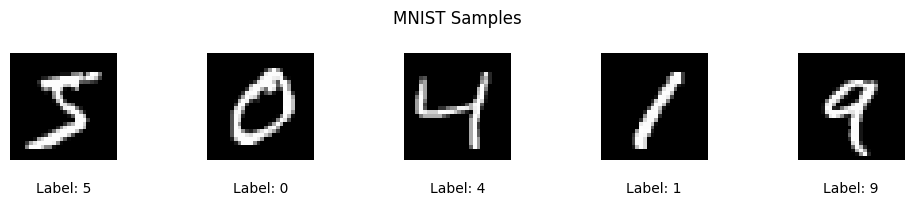


Dataset: CIFAR-10
Training set size: 50000
Test set size: 10000
Number of unique classes: 10
Sample image shape: torch.Size([3, 32, 32])


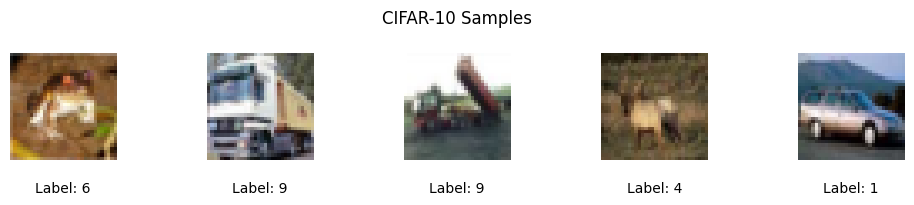

In [ ]:
# Here we print the details of the datasets and visualize some samples from each.
print("Dataset: MNIST")
print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test)}")
print(f"Number of unique classes: {len(mnist_train.classes)}")
mnist_sample,_ = mnist_train[0]
print(f"Sample image shape: {mnist_sample.shape}")
show_samples(mnist_train, "MNIST Samples", mean=(0.5,), std=(0.5,))

print("\nDataset: CIFAR-10")
print(f"Training set size: {len(cifar_train)}")
print(f"Test set size: {len(cifar_test)}")
print(f"Number of unique classes: {len(cifar_train.classes)}")
cifar_sample,_ = cifar_train[0]
print(f"Sample image shape: {cifar_sample.shape}")
show_samples(cifar_train, "CIFAR-10 Samples", mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


## 3. Training model from scratch

In [ ]:
# This section defines two neural network architectures:
# 1. MNIST_Net - A fully connected neural network for classifying handwritten digits from the MNIST dataset.
# 2. CIFAR_Net - A convolutional neural network (CNN) for classifying images from the CIFAR-10 dataset.

class MNIST_Net(nn.Module):
    """
    `MNIST_Net` is a simple three-layer fully connected neural network that flattens 28×28 images and maps
    them through layers of sizes 128, 64, and 10 for digit classification.
    """
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CIFAR_Net(nn.Module):
    """
    `CIFAR_Net` is a basic CNN with two convolutional layers (32→64 filters), max pooling,
     and two fully connected layers that classify 32×32 RGB images into 10 classes.
    """
    def __init__(self):
        super(CIFAR_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Training function
def train_model(model, train_loader, epochs=2, lr=0.001):
    """
    The `train_model` function trains a given model using the Adam optimizer and cross-entropy loss over a specified
    number of epochs. It moves the model to the available device (CPU/GPU), computes the number of trainable parameters,
    and iteratively updates model weights using backpropagation. During training, it tracks and prints the loss after
    each epoch, and finally visualizes the loss trend across epochs using a line plot.
    """
    model.to(device)
    print("Number of parameters in the model are: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Plot loss curve
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

# Testing function
def test_model(model, test_loader):
    """
    The `test_model` function evaluates a trained model's performance on a test dataset by calculating its overall accuracy.
    It sets the model to evaluation mode, disables gradient computation for efficiency, and compares predicted labels to
    ground truth across the test set. The final accuracy is printed as a percentage.
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

Training MNIST Model...
Number of parameters in the model are:  109386


100%|██████████| 938/938 [00:14<00:00, 65.23it/s]


Epoch 1, Loss: 0.4150


100%|██████████| 938/938 [00:18<00:00, 51.06it/s]


Epoch 2, Loss: 0.2037


100%|██████████| 938/938 [00:13<00:00, 70.41it/s]


Epoch 3, Loss: 0.1493


100%|██████████| 938/938 [00:13<00:00, 70.40it/s]


Epoch 4, Loss: 0.1225


100%|██████████| 938/938 [00:13<00:00, 69.17it/s]


Epoch 5, Loss: 0.1044


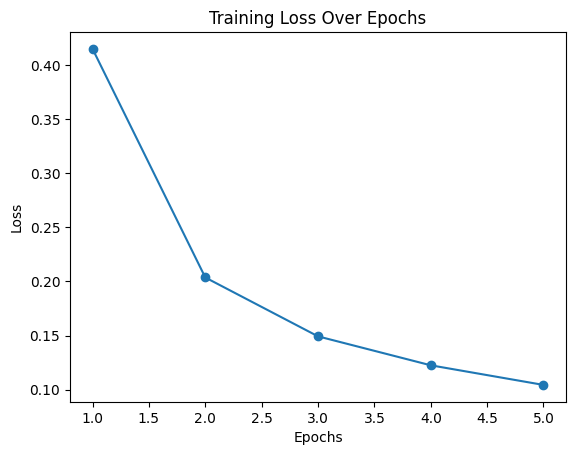

Testing MNIST Model...


100%|██████████| 157/157 [00:01<00:00, 80.21it/s]


Accuracy: 96.46%



Training CIFAR-10 Model...
Number of parameters in the model are:  545098


100%|██████████| 782/782 [00:18<00:00, 41.86it/s]


Epoch 1, Loss: 1.3512


100%|██████████| 782/782 [00:15<00:00, 51.36it/s]


Epoch 2, Loss: 0.9651


100%|██████████| 782/782 [00:16<00:00, 46.41it/s]


Epoch 3, Loss: 0.8046


100%|██████████| 782/782 [00:18<00:00, 41.86it/s]


Epoch 4, Loss: 0.6845


100%|██████████| 782/782 [00:15<00:00, 51.17it/s]


Epoch 5, Loss: 0.5797


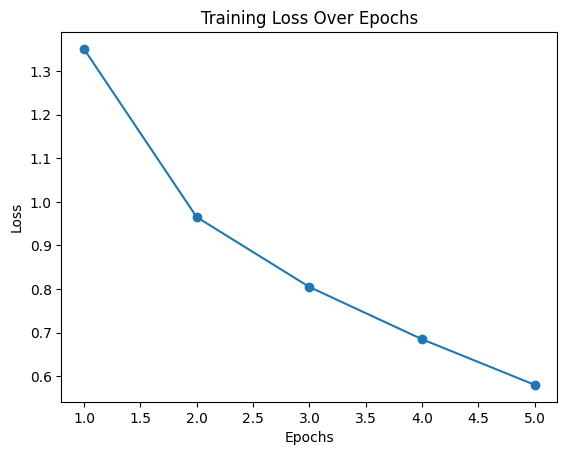

Testing CIFAR-10 Model...


100%|██████████| 157/157 [00:02<00:00, 64.73it/s]

Accuracy: 71.95%


In [ ]:
# Train & Test MNIST Model
mnist_model = MNIST_Net()
print("Training MNIST Model...")
train_model(mnist_model, mnist_loader_train, epochs=5) # feel free to adjust the number of epochs to optimise performance
print("Testing MNIST Model...")
test_model(mnist_model, mnist_loader_test)
print("\n\n")
# Train & Test CIFAR-10 Model
cifar_model = CIFAR_Net()
print("Training CIFAR-10 Model...")
train_model(cifar_model, cifar_loader_train, epochs=5) # feel free to adjust the number of epochs to optimise performance
print("Testing CIFAR-10 Model...")
test_model(cifar_model, cifar_loader_test)


Visualizing MNIST Predictions.


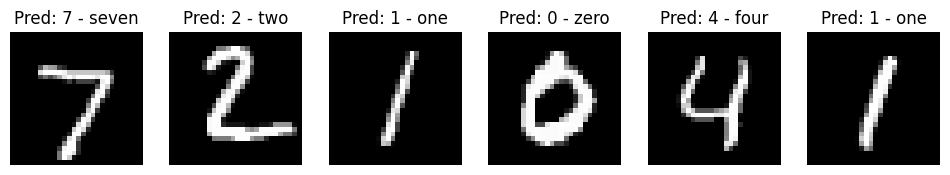



Visualizing CIFAR-10 Predictions.


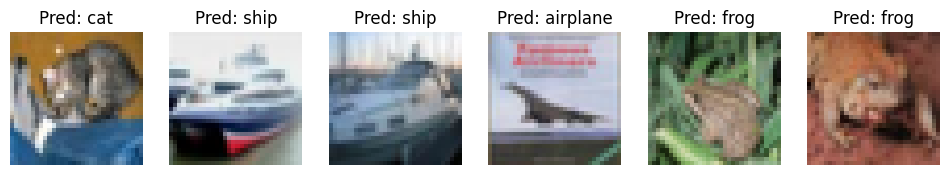

In [ ]:
print("Visualizing MNIST Predictions.")
mnist_classes = mnist_train.classes
visualize_predictions(mnist_model, mnist_loader_test, mnist_classes)

print("\n\nVisualizing CIFAR-10 Predictions.")
cifar_classes = cifar_train.classes
visualize_predictions(cifar_model, cifar_loader_test, cifar_classes)


## 4. Finetuning the pretrained models (GPU required)

We will explore fine-tuning, a technique in deep learning where we take a pre-trained model and adapt it to a new task by updating all of its layers(in our case). Instead of training a model from scratch, fine-tuning leverages knowledge from a model trained on a large dataset (e.g., ImageNet) and refines it on a smaller, task-specific dataset. We utilize pretrained Swin Transformer Tiny model as our classifier. To keep the compute feasible we consider a binary classification task where we finetune it on a 2 class subset of CIFAR-10, and evaluate how well the model adapts to the new classification task. This approach helps achieve higher accuracy with fewer training resources while maintaining the benefits of learned feature representations.

In [ ]:
# Loading the Swin transformer Tiny model
"""
Here we load a pretrained Swin Transformer model (`swin_tiny_patch4_window7_224`) using the `timm` library.
Its final classification layer is replaced with a new fully connected layer having 2 output nodes for binary classification.
The model is set to training mode to begin the fine-tuning process on a new task.
"""
modelswinT = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
num_classes = 2
modelswinT.head.fc = nn.Linear(modelswinT.head.fc.in_features, num_classes) # replace the last layer with a 2 node for the binary classification task.
modelswinT.train()
modelswinT.to(device)
print("Number of parameters in the model are:", sum(p.numel() for p in modelswinT.parameters() if p.requires_grad))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Number of parameters in the model are: 27520892


In [ ]:
#Here we first load the complete CIFAR-10 dataset and do a preliminary transformation so that further processing can be done.
full_cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_cifar_resized)
full_cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_cifar_resized)



# Using the filter_class() defined earlier we filter out the first two classes and create a subset.
classes_to_keep = {0, 1}
cifar_train_binary = filter_classes(full_cifar_train, classes_to_keep)
cifar_test_binary = filter_classes(full_cifar_test, classes_to_keep)

# Define DataLoaders
batch_size = 32

cifar_loader_train_binary = DataLoader(cifar_train_binary, batch_size=batch_size, shuffle=True)
cifar_loader_test_binary = DataLoader(cifar_test_binary, batch_size=batch_size, shuffle=False)

Number of parameters in the model are:  27520892


100%|██████████| 313/313 [02:10<00:00,  2.39it/s]


Epoch 1, Loss: 0.0472


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch 2, Loss: 0.0187


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch 3, Loss: 0.0138


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch 4, Loss: 0.0114


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch 5, Loss: 0.0110


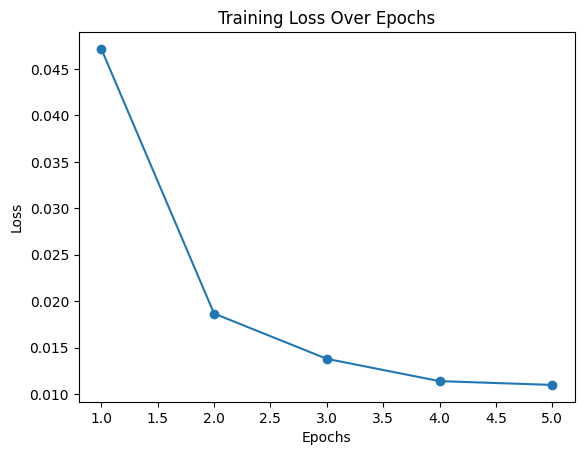

100%|██████████| 63/63 [00:10<00:00,  5.84it/s]

Accuracy: 99.65%


In [ ]:
train_model(modelswinT, cifar_loader_train_binary, epochs=5,lr=0.0001)# a lower learning rate is kept so that pretrained weights are not altered a lot.
test_model(modelswinT, cifar_loader_test_binary)

Visualizing Predictions.


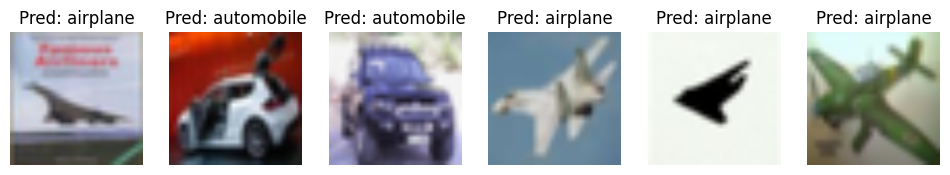

In [ ]:
print("Visualizing Predictions.")
visualize_predictions(modelswinT, cifar_loader_test_binary, ['airplane','automobile'])

## 5. Performance evaluation
Here, we evaluate the classifier's performance using key metrics such as **Precision, Recall, F1-score, and Support**, while also analyzing **True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)**. These metrics provide insights into the effectiveness of our model in distinguishing between different classes.

### Confusion Matrix Table

| Actual \ Predicted | **Predicted Positive** | **Predicted Negative** |
|--------------------|----------------------|----------------------|
| **Actual Positive** | ✅ **True Positive (TP)**  | ❌ **False Negative (FN)** |
| **Actual Negative** | ❌ **False Positive (FP)** | ✅ **True Negative (TN)** |


### **Metric Definitions & Formulations**
1. **Precision** – Measures how many of the predicted positive instances were actually correct.  
   $$\text{Precision} = \frac{TP}{TP + FP}$$

2. **Recall (Sensitivity)** – Measures how many actual positive instances were correctly predicted.  

   $$\text{Recall} = \frac{TP}{TP + FN}$$

3. **F1-Score** – The harmonic mean of Precision and Recall, providing a balance between the two.  
   
   $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

4. **Support** – The number of actual occurrences of each class in the dataset.

These metrics help assess the classifier's robustness and ensure a comprehensive evaluation of its performance.


Classification report:

              precision    recall  f1-score   support

    airplane       1.00      0.99      1.00      1000
  automobile       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion matrix
airplane: TP=995, FP=2, FN=5, TN=998
automobile: TP=998, FP=5, FN=2, TN=995


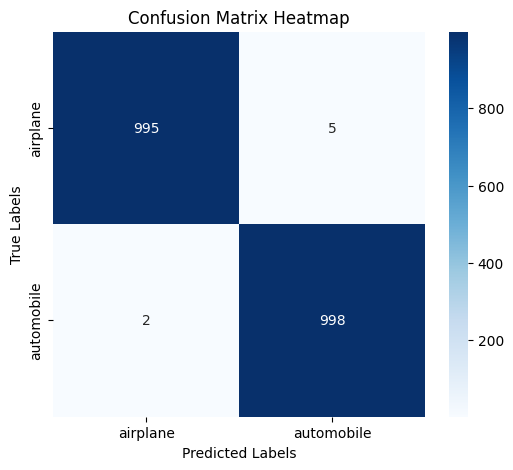

In [ ]:
print("Classification report:\n")
get_classification_report(modelswinT, cifar_loader_test_binary, ['airplane','automobile'])
print("Confusion matrix")
get_confusion_matrix(modelswinT, cifar_loader_test_binary, ['airplane','automobile'])

----------------------------------------------------------------------------------------------------THE END----------------------------------------------------------------------------------------------------
